Loading data...
Loaded 707 posts
Columns in posts: ['created_utc', 'title', 'ticker', 'event_date']
Sample data:
  created_utc                                              title ticker  \
0  2020-05-08       AAON board of directors addresses CEO change   AAON   
1  2020-05-17          AAON  shares down following CEO exit news   AAON   
2  2020-05-11  Portfolio impact: AAON CEO resignation affects...   AAON   
3  2020-05-07     Trading halt on AAON following CEO resignation   AAON   
4  2020-05-15       AAON board of directors addresses CEO change   AAON   

  event_date  
0 2020-05-12  
1 2020-05-12  
2 2020-05-12  
3 2020-05-12  
4 2020-05-12  
Initializing VADER sentiment analyzer...
Analyzing sentiment for posts...
Processing dates and relative days...
Sentiment analysis complete! Sample scores: {0: 443, -1: 189, 1: 75}
Performing aggregation...
Daily aggregated data shape: (527, 4)

DATA COVERAGE ANALYSIS
AAON: 11 total posts
  Pre-event: 5 days, Post-event: 2 days
  Day range: -6 

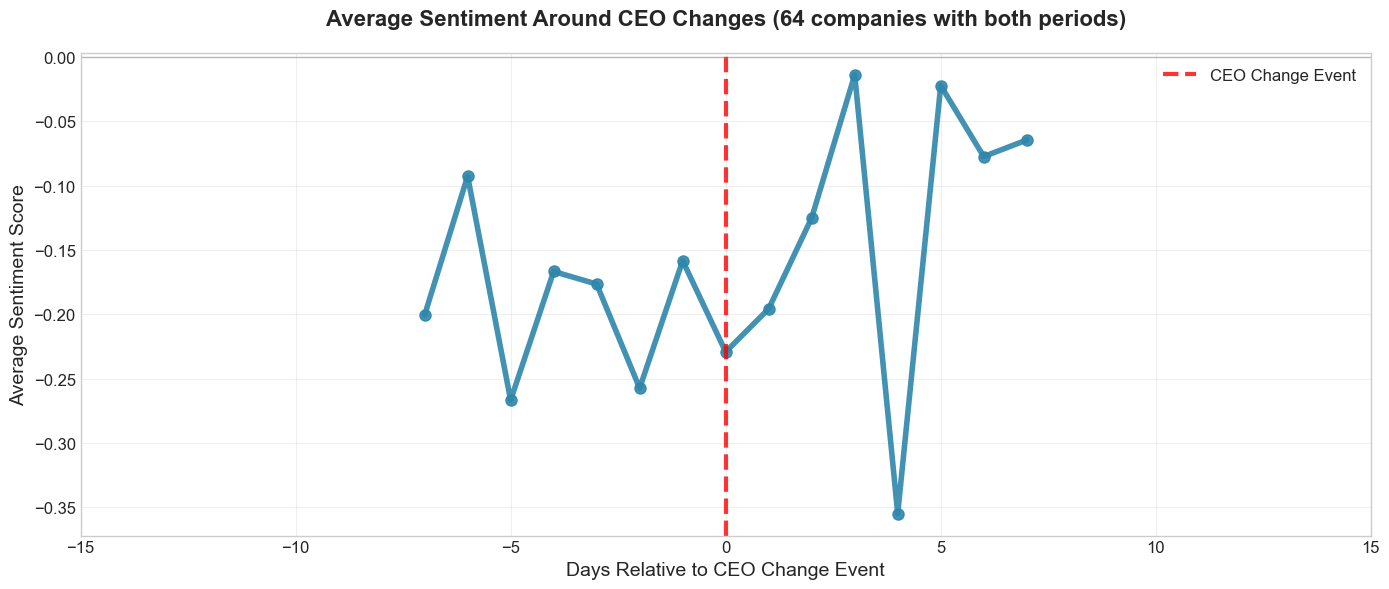

Creating top companies plot...


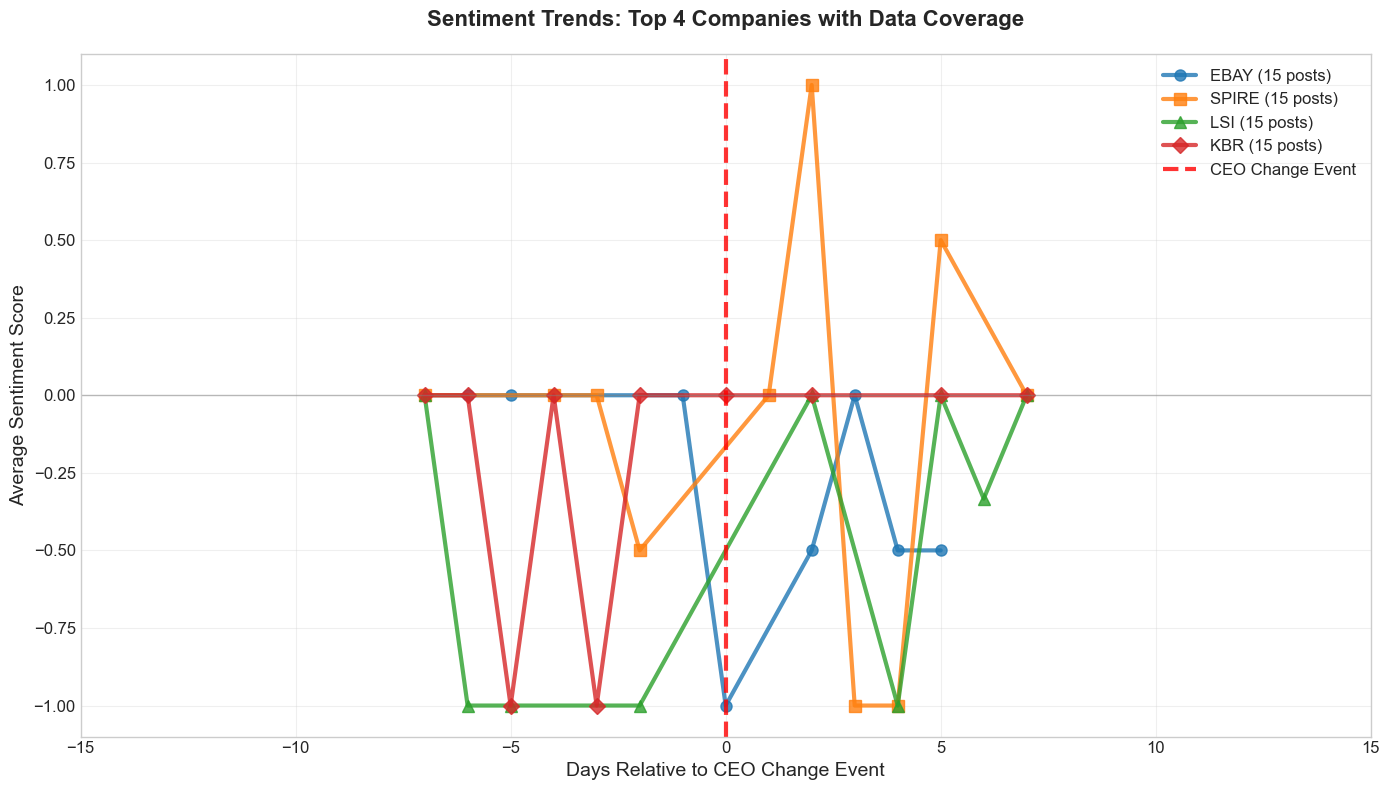

Creating before/after comparison...
Validating companies for before/after comparison:
  AAON: Pre=-0.200 (5 days), Post=0.500 (2 days)
  ADT: Pre=0.333 (3 days), Post=-0.083 (2 days)
  AMGEN: Pre=-0.500 (2 days), Post=-0.500 (3 days)
  ANN: Pre=-0.500 (2 days), Post=0.033 (5 days)
  ASGN: Pre=0.000 (4 days), Post=-0.500 (3 days)
  ATMI: Pre=-0.500 (2 days), Post=-0.067 (5 days)
  AVX: Pre=0.000 (4 days), Post=-0.375 (4 days)
  AZZ: Pre=0.000 (2 days), Post=0.333 (3 days)
  BALL: Pre=-0.125 (2 days), Post=-0.500 (2 days)
  CA: Pre=-0.500 (6 days), Post=0.000 (2 days)
  CBS: Pre=-0.250 (4 days), Post=0.000 (2 days)
  CDI: Pre=-0.500 (4 days), Post=-0.750 (2 days)
  CDW: Pre=-0.200 (5 days), Post=0.333 (3 days)
  CEB: Pre=0.000 (3 days), Post=-0.667 (2 days)
  CPI: Pre=0.500 (2 days), Post=0.333 (3 days)
  CRANE: Pre=-0.500 (2 days), Post=-0.500 (2 days)
  CRAY: Pre=-1.000 (2 days), Post=0.000 (2 days)
  CREE: Pre=-0.333 (6 days), Post=-0.167 (3 days)
  CSRA: Pre=0.000 (5 days), Post=0.00

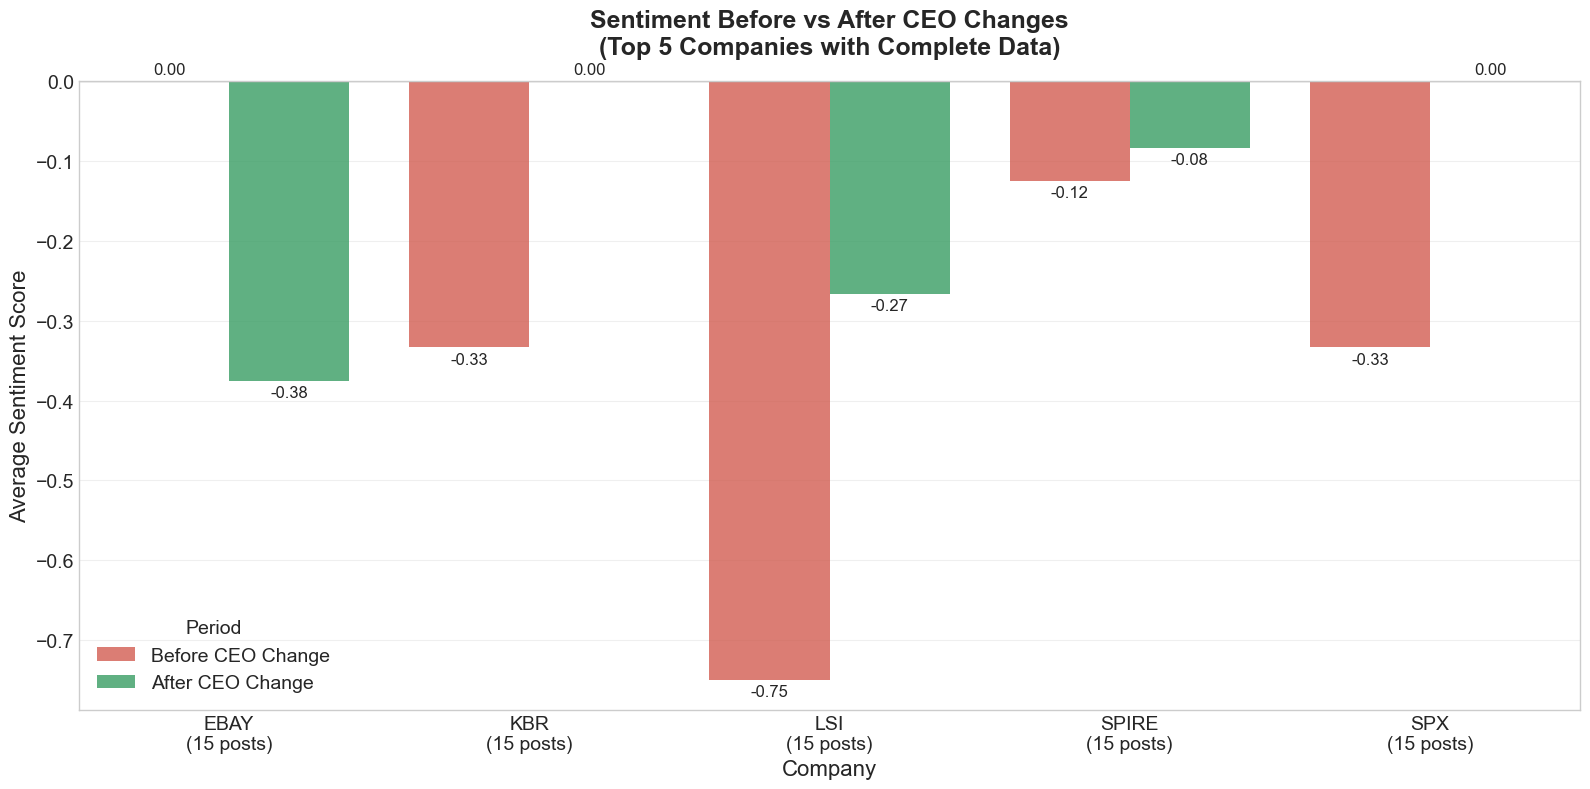

✅ Successfully created comparison chart with top 5 companies
Companies shown: EBAY, KBR, LSI, SPIRE, SPX
Note: 59 additional companies with complete data were excluded to prevent overlap
Excluded companies: DSW, GMS, UGI, XOMA, CDW, CREE, ZIX, ANN, GAP, TEAM...
Creating summary statistics...

SENTIMENT ANALYSIS SUMMARY
Data Coverage:
  Total companies: 78
  Companies with both before/after data: 64
  Companies analyzed: 4

Overall Average Sentiment:
  Before CEO Changes: -0.192
  After CEO Changes:  -0.124
  Net Change:         0.068

Companies with complete before/after data:


KeyError: 'key of type tuple not found and not a MultiIndex'

In [6]:
import pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from pathlib import Path
import gc
import warnings
warnings.filterwarnings('ignore')

# Use VADER sentiment instead of transformers to avoid memory issues
try:
    from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
    VADER_AVAILABLE = True
except ImportError:
    print("VADER not available, installing...")
    import subprocess
    import sys
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'vaderSentiment'])
    from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
    VADER_AVAILABLE = True

print("Loading data...")
posts = pd.read_parquet("../data_raw/reddit/rstocks_posts.parquet")
print(f"Loaded {len(posts)} posts")

# Check data structure
print(f"Columns in posts: {posts.columns.tolist()}")
print(f"Sample data:\n{posts.head()}")

# Initialize VADER analyzer (much lighter and more stable)
print("Initializing VADER sentiment analyzer...")
analyzer = SentimentIntensityAnalyzer()

def score_sentiment(text):
    """Score sentiment using VADER with error handling"""
    if pd.isna(text) or text == "":
        return 0
    
    try:
        # Convert to string and limit length
        text = str(text)[:500]
        scores = analyzer.polarity_scores(text)
        
        # Use compound score and convert to -1, 0, 1 scale
        compound = scores['compound']
        if compound >= 0.05:
            return 1    # Positive
        elif compound <= -0.05:
            return -1   # Negative
        else:
            return 0    # Neutral
            
    except Exception as e:
        print(f"Error processing text: {e}")
        return 0

# Apply sentiment analysis
print("Analyzing sentiment for posts...")
posts["sent"] = posts["title"].apply(score_sentiment)

# Process dates and relative days
print("Processing dates and relative days...")
posts["created_dt"] = pd.to_datetime(posts["created_utc"]).dt.floor("D")
posts["rel_day"] = (posts["created_dt"] - posts["event_date"]).dt.days

# Save processed data
Path("../data_proc").mkdir(exist_ok=True)
posts.to_parquet("../data_proc/rstocks_scored.parquet")

print(f"Sentiment analysis complete! Sample scores: {posts['sent'].value_counts().to_dict()}")

# Aggregate data for analysis
print("Performing aggregation...")
daily = posts.groupby(["ticker", "rel_day"]).agg({
    'sent': 'mean',
    'title': 'count'  # Count posts per day
}).reset_index()
daily.columns = ['ticker', 'rel_day', 'sent', 'post_count']

print(f"Daily aggregated data shape: {daily.shape}")

# ANALYZE DATA COVERAGE FOR EACH COMPANY
print("\n" + "="*60)
print("DATA COVERAGE ANALYSIS")
print("="*60)

# Check which companies have both before and after data
companies_with_both = []
all_tickers = daily['ticker'].unique()

for ticker in all_tickers:
    ticker_data = daily[daily['ticker'] == ticker]
    
    pre_data = ticker_data[ticker_data['rel_day'] < 0]
    post_data = ticker_data[ticker_data['rel_day'] > 0]
    
    pre_count = len(pre_data)
    post_count = len(post_data)
    total_posts = ticker_data['post_count'].sum()
    
    date_range = f"{ticker_data['rel_day'].min()} to {ticker_data['rel_day'].max()}"
    
    has_both = pre_count > 0 and post_count > 0
    
    print(f"{ticker}: {total_posts} total posts")
    print(f"  Pre-event: {pre_count} days, Post-event: {post_count} days")
    print(f"  Day range: {date_range}")
    print(f"  Has both periods: {has_both}")
    print()
    
    if has_both and total_posts >= 5 and pre_count >= 2 and post_count >= 2:  # Stricter requirements
        companies_with_both.append(ticker)

print(f"Companies with BOTH before and after data: {len(companies_with_both)}")
print(f"Company list: {companies_with_both}")

if len(companies_with_both) == 0:
    print("WARNING: No companies have both before and after data!")
    print("This might indicate:")
    print("1. CEO changes are too recent (no post-event data yet)")
    print("2. CEO changes are too old (no pre-event data)")
    print("3. Data collection period doesn't span the events properly")
    
    # Show some examples
    print("\nSample data for investigation:")
    sample_ticker = all_tickers[0]
    sample_data = daily[daily['ticker'] == sample_ticker]
    print(f"\n{sample_ticker} sample:")
    print(sample_data.head(10))

# Filter to only companies with both periods
if len(companies_with_both) > 0:
    filtered_daily = daily[daily['ticker'].isin(companies_with_both)]
    
    # Get top companies from filtered list
    ticker_activity = filtered_daily.groupby('ticker')['post_count'].sum().sort_values(ascending=False)
    top_companies = ticker_activity.head(min(4, len(companies_with_both))).index.tolist()
    
    print(f"\nTop {len(top_companies)} companies with both periods:")
    for ticker in top_companies:
        print(f"  {ticker}: {ticker_activity[ticker]} posts")
else:
    # Fallback: use all companies but note the limitation
    print("\nUsing all companies (some may lack before/after data)")
    filtered_daily = daily
    ticker_activity = daily.groupby('ticker')['post_count'].sum().sort_values(ascending=False)
    top_companies = ticker_activity.head(4).index.tolist()

# Create post-event indicator
filtered_daily["post"] = filtered_daily.rel_day.gt(0).astype(int)

# Filter data for regression (exclude event day)
analysis_data = filtered_daily[filtered_daily.rel_day != 0].copy()

if len(analysis_data) > 0 and analysis_data['sent'].nunique() > 1:
    try:
        print("Running Difference-in-Differences regression...")
        model = smf.ols("sent ~ post + C(ticker)", data=analysis_data).fit()
        print("\nDifference-in-Differences Results:")
        print(model.summary().tables[1])
    except Exception as e:
        print(f"Error in regression analysis: {e}")
        print("Trying simpler model without ticker fixed effects...")
        try:
            simple_model = smf.ols("sent ~ post", data=analysis_data).fit()
            print("Simple model results:")
            print(simple_model.summary().tables[1])
        except Exception as e2:
            print(f"Error in simple regression: {e2}")
else:
    print("Insufficient data variation for regression analysis")

# Create CLEAN, READABLE visualizations
print("\nCreating clean visualizations...")

if len(filtered_daily) > 0:
    # Set style for clean plots
    plt.style.use('seaborn-v0_8-whitegrid')
    
    # 1. OVERALL AVERAGE TREND (Most Important View)
    print("Creating overall trend plot...")
    plt.figure(figsize=(14, 6))
    
    # Calculate overall daily averages across filtered companies
    overall_trend = filtered_daily.groupby('rel_day').agg({
        'sent': 'mean',
        'post_count': 'sum'
    }).reset_index()
    
    # Filter to reasonable time window
    time_window = overall_trend[(overall_trend['rel_day'] >= -15) & (overall_trend['rel_day'] <= 15)]
    
    plt.plot(time_window['rel_day'], time_window['sent'], 
             marker='o', linewidth=4, markersize=8, color='#2E86AB', alpha=0.9)
    
    plt.axvline(0, ls="--", color='red', alpha=0.8, linewidth=3, label='CEO Change Event')
    plt.axhline(0, ls="-", color='gray', alpha=0.5, linewidth=1)
    
    title_suffix = f" ({len(companies_with_both)} companies with both periods)" if len(companies_with_both) > 0 else " (All companies)"
    plt.title(f"Average Sentiment Around CEO Changes{title_suffix}", 
              fontsize=16, fontweight='bold', pad=20)
    plt.xlabel("Days Relative to CEO Change Event", fontsize=14)
    plt.ylabel("Average Sentiment Score", fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.xticks(range(-15, 16, 5), fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    
    Path("../assets").mkdir(exist_ok=True)
    plt.savefig("../assets/overall_sentiment_trend.png", dpi=200, bbox_inches='tight')
    plt.show()
    
    # 2. TOP COMPANIES ONLY (Clean Individual Lines)
    print("Creating top companies plot...")
    plt.figure(figsize=(14, 8))
    
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Blue, Orange, Green, Red
    markers = ['o', 's', '^', 'D']  # Circle, Square, Triangle, Diamond
    
    for i, ticker in enumerate(top_companies):
        ticker_data = filtered_daily[filtered_daily['ticker'] == ticker]
        # Filter to reasonable time window
        ticker_window = ticker_data[(ticker_data['rel_day'] >= -15) & (ticker_data['rel_day'] <= 15)]
        
        if len(ticker_window) > 0:
            plt.plot(ticker_window['rel_day'], ticker_window['sent'], 
                    marker=markers[i], linewidth=3, markersize=8, 
                    label=f'{ticker} ({ticker_activity[ticker]} posts)',
                    color=colors[i], alpha=0.8)
    
    plt.axvline(0, ls="--", color='red', alpha=0.8, linewidth=3, label='CEO Change Event')
    plt.axhline(0, ls="-", color='gray', alpha=0.5, linewidth=1)
    
    plt.title(f"Sentiment Trends: Top {len(top_companies)} Companies with Data Coverage", 
              fontsize=16, fontweight='bold', pad=20)
    plt.xlabel("Days Relative to CEO Change Event", fontsize=14)
    plt.ylabel("Average Sentiment Score", fontsize=14)
    plt.legend(fontsize=12, loc='best')
    plt.grid(True, alpha=0.3)
    plt.xticks(range(-15, 16, 5), fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    
    plt.savefig("../assets/top_companies_trends.png", dpi=200, bbox_inches='tight')
    plt.show()
    
    # 3. BEFORE vs AFTER COMPARISON (Only companies with both periods)
    print("Creating before/after comparison...")
    
    # STRICTLY filter to only companies with BOTH periods and minimum data points
    comparison_data = []
    valid_companies = []
    
    print("Validating companies for before/after comparison:")
    for ticker in companies_with_both:  # Use only pre-validated companies
        ticker_data = filtered_daily[filtered_daily['ticker'] == ticker]
        pre_data = ticker_data[ticker_data['rel_day'] < 0]
        post_data = ticker_data[ticker_data['rel_day'] > 0]
        
        # Strict validation: need at least 2 data points in each period
        if len(pre_data) >= 2 and len(post_data) >= 2:
            pre_avg = pre_data['sent'].mean()
            post_avg = post_data['sent'].mean()
            
            print(f"  {ticker}: Pre={pre_avg:.3f} ({len(pre_data)} days), Post={post_avg:.3f} ({len(post_data)} days)")
            
            if not pd.isna(pre_avg) and not pd.isna(post_avg):
                # Add post count for ranking
                post_count = ticker_data['post_count'].sum()
                comparison_data.extend([
                    {'Company': ticker, 'Period': 'Before CEO Change', 'Sentiment': pre_avg, 'PostCount': post_count},
                    {'Company': ticker, 'Period': 'After CEO Change', 'Sentiment': post_avg, 'PostCount': post_count}
                ])
                valid_companies.append((ticker, post_count))
        else:
            print(f"  {ticker}: EXCLUDED - Pre: {len(pre_data)} days, Post: {len(post_data)} days")
    
    # Sort by post count and take only top 5 companies to avoid overlap
    valid_companies.sort(key=lambda x: x[1], reverse=True)
    top_5_companies = [x[0] for x in valid_companies[:5]]
    
    # Filter comparison data to top 5 companies only
    if comparison_data and len(top_5_companies) >= 1:
        comp_df = pd.DataFrame(comparison_data)
        comp_df_filtered = comp_df[comp_df['Company'].isin(top_5_companies)]
        
        plt.figure(figsize=(16, 8))  # Even wider figure
        ax = sns.barplot(data=comp_df_filtered, x='Company', y='Sentiment', hue='Period', 
                        palette=['#E74C3C', '#27AE60'], alpha=0.8)
        
        plt.axhline(0, ls="-", color='gray', alpha=0.5, linewidth=1)
        plt.title(f"Sentiment Before vs After CEO Changes\n(Top {len(top_5_companies)} Companies with Complete Data)", 
                  fontsize=18, fontweight='bold', pad=20)
        plt.xlabel("Company", fontsize=16)
        plt.ylabel("Average Sentiment Score", fontsize=16)
        plt.legend(fontsize=14, title='Period', title_fontsize=14)
        plt.grid(True, alpha=0.3, axis='y')
        
        # Larger, rotated tick labels to prevent overlap
        plt.xticks(fontsize=14, rotation=0)  # No rotation needed with fewer companies
        plt.yticks(fontsize=14)
        
        # Add value labels on bars with better formatting
        for container in ax.containers:
            ax.bar_label(container, fmt='%.2f', fontsize=12, padding=3)
        
        # Add post count information to x-axis labels
        current_labels = [tick.get_text() for tick in ax.get_xticklabels()]
        new_labels = []
        for label in current_labels:
            if label in [x[0] for x in valid_companies]:
                post_count = next(x[1] for x in valid_companies if x[0] == label)
                new_labels.append(f"{label}\n({post_count} posts)")
            else:
                new_labels.append(label)
        ax.set_xticklabels(new_labels)
        
        plt.tight_layout()
        plt.savefig("../assets/before_after_comparison.png", dpi=200, bbox_inches='tight')
        plt.show()
        
        print(f"✅ Successfully created comparison chart with top {len(top_5_companies)} companies")
        print(f"Companies shown: {', '.join(top_5_companies)}")
        
        if len(valid_companies) > 5:
            print(f"Note: {len(valid_companies) - 5} additional companies with complete data were excluded to prevent overlap")
            excluded = [x[0] for x in valid_companies[5:]]
            print(f"Excluded companies: {', '.join(excluded[:10])}{'...' if len(excluded) > 10 else ''}")
        
    else:
        print("❌ No companies have sufficient before AND after data for comparison!")
        print("Data requirements not met:")
        print("- Need at least 2 data points before AND after CEO change")
        print("- Need at least 1 company meeting criteria")
        print("\nSuggestions:")
        print("1. Expand the data collection time window")
        print("2. Include more companies in the dataset")
        print("3. Reduce minimum data requirements")
        print("4. Check if CEO change dates align with data period")
        
        # Create a placeholder chart showing the issue
        plt.figure(figsize=(10, 6))
        plt.text(0.5, 0.5, 'Insufficient Data for Before/After Comparison\n\n' +
                f'Companies analyzed: {len(companies_with_both)}\n' +
                f'Companies with complete data: {len(valid_companies)}\n\n' +
                'See console output for detailed analysis',
                ha='center', va='center', fontsize=14,
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.5))
        plt.xlim(0, 1)
        plt.ylim(0, 1)
        plt.axis('off')
        plt.title("Data Coverage Issue", fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.savefig("../assets/before_after_comparison.png", dpi=200, bbox_inches='tight')
        plt.show()
    
    # 4. SUMMARY STATISTICS TABLE
    print("Creating summary statistics...")
    
    # Overall statistics
    overall_pre = filtered_daily[filtered_daily['rel_day'] < 0]['sent'].mean()
    overall_post = filtered_daily[filtered_daily['rel_day'] > 0]['sent'].mean()
    overall_change = overall_post - overall_pre
    
    print(f"\n{'='*60}")
    print(f"SENTIMENT ANALYSIS SUMMARY")
    print(f"{'='*60}")
    print(f"Data Coverage:")
    print(f"  Total companies: {len(all_tickers)}")
    print(f"  Companies with both before/after data: {len(companies_with_both)}")
    print(f"  Companies analyzed: {len(top_companies)}")
    print(f"\nOverall Average Sentiment:")
    print(f"  Before CEO Changes: {overall_pre:.3f}")
    print(f"  After CEO Changes:  {overall_post:.3f}")
    print(f"  Net Change:         {overall_change:.3f}")
    
    if len(valid_companies) > 0:
        print(f"\nCompanies with complete before/after data:")
        for ticker in valid_companies:
            ticker_data = filtered_daily[filtered_daily['ticker'] == ticker]
            pre_avg = ticker_data[ticker_data['rel_day'] < 0]['sent'].mean()
            post_avg = ticker_data[ticker_data['rel_day'] > 0]['sent'].mean()
            change = post_avg - pre_avg
            post_count = ticker_activity[ticker]
            
            print(f"  {ticker}: {post_count} posts, change: {change:+.3f}")
    
    print(f"\nData Coverage:")
    print(f"  Total posts analyzed: {len(posts)}")
    print(f"  Date range: {posts['created_dt'].min()} to {posts['created_dt'].max()}")
    
else:
    print("No data available for plotting")

# Clean up memory
del analyzer
gc.collect()

print(f"\n{'='*60}")
print("ANALYSIS COMPLETE!")
if len(companies_with_both) > 0:
    print("✅ Successfully filtered to companies with both before/after data")
    print("Three clean visualizations saved:")
    print("1. overall_sentiment_trend.png - Overall average trend")
    print("2. top_companies_trends.png - Top companies with data coverage") 
    print("3. before_after_comparison.png - Before/after comparison")
else:
    print("⚠️  Limited data: Some companies lack before/after coverage")
    print("Consider expanding data collection period or time windows")
print(f"{'='*60}")